# Making additional datasets

Here we make additional datasets that we can use to scrape the GDELT dataset. We need:

1. A list of all the themes we want to scrape
2. A list of all the countries we want to scrape, the ways they can be referred to, and the way they are labelled in GDELT

In [9]:
import pandas as pd
import urllib.parse
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import requests
from bs4 import BeautifulSoup
import re
import pickle

# surpress future warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. List of Themes

### 1.1 Exploring the themes

When we import the theme lookup file GDELT provides we can see that there are `59315` themes. This is too many to use in our analysis, so we can select a subset first based on the distribution.

In [10]:
theme_url = "http://data.gdeltproject.org/api/v2/guides/LOOKUP-GKGTHEMES.TXT"
theme_df = pd.read_csv(theme_url, sep='\t', header=None)
print(len(theme_df))

59315


We can check the distribution to see if we can lower this amount in a meaningful way.

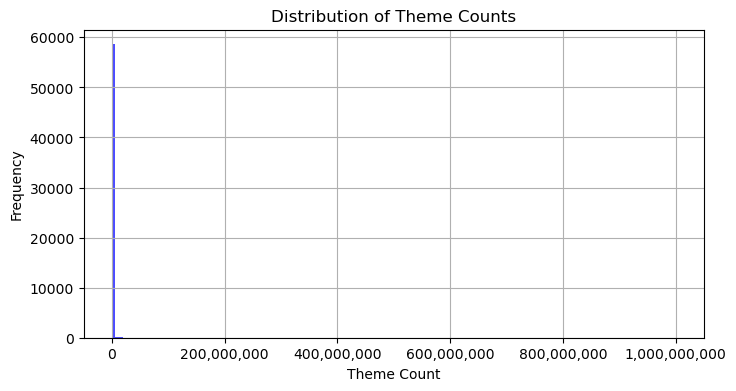

In [11]:
theme_counts = theme_df[1]

plt.figure(figsize=(8, 4))
plt.hist(theme_counts, bins=200, color='blue', alpha=0.7)
plt.title('Distribution of Theme Counts')
plt.xlabel('Theme Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
plt.show()

We find that most of the themes have very low counts. It might be useful to filter out the themes with low counts. We can do this by setting a threshold for the minimum number of counts. Let's see how many there are in this format

In [12]:
print(len(theme_df[theme_df[1] < 10]))
print(len(theme_df[theme_df[1] < 100]))
print(len(theme_df[theme_df[1] < 100000]))

20246
33974
55061


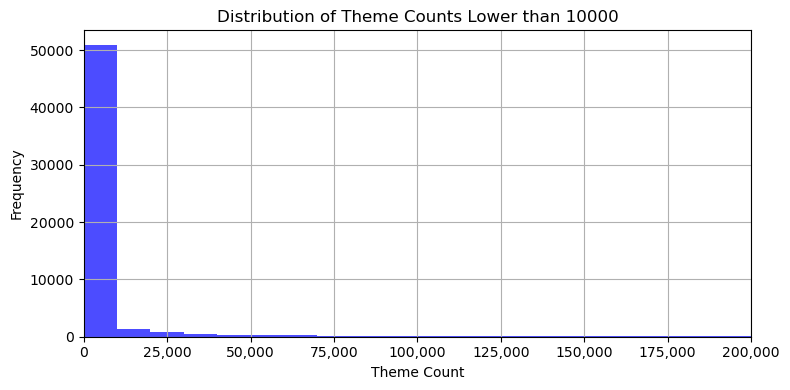

In [13]:
def plot_dist(df ,subset_title, bins, x_upper_lim):
    plt.figure(figsize=(8, 4))
    plt.hist(df, bins=bins, color="blue", alpha=0.7)
    plt.title(f'Distribution of Theme Counts {subset_title}')
    plt.xlabel('Theme Count')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.xlim(0, x_upper_lim)
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
    plt.tight_layout()
    return plt

plt = plot_dist(theme_df[theme_df[1] < 200000][1], 'Lower than 10000', 20, 200000)
plt.show()

Based on the distribution, we will filter out all themes that occur less than 100.000 times. This might seem like a harsh treshhold, but we are talking about 7 years of news coverage and millions of news articles, so themes that occur less than 100.000 times are not very relevant for our analysis. This leaves us with `4254` themes.

In [14]:
theme_filtered = theme_df[theme_df[1] > 100000]
themes_list = theme_filtered[0].tolist()
len(themes_list)

themes_path = 'saves/themes_list.pickle'

with open(themes_path, 'wb') as f:
    pickle.dump(themes_list, f)

Now we want to scrape the data for all these themes, and then perform analysis to check correlations with both conflict, and periods before conflict. This will require some data wrangling and the incorporation of the UCDP data, but the first step is to retrieve the data from GDELT. In the end we will mak a dictionary with ways that countries can be referred to, but for test purposes we will first scrape all locally published theme data, and make faulty assumption that all articles published in country x also concern country x. This is not true, but it is a good starting point.

## 2. List of Countries, their capitals, and the way they can be referred to in GDELT

### 2.1 List of Country names and FIPS from GDELT

We first retrieve a list of unique countries from the FIPS country codes that GDELT uses, and dump it to a pickle file

In [15]:
with open("saves/gdeltcountries.html", "r") as file:
    html_content = file.read()

soup = BeautifulSoup(html_content, 'html.parser')
countries_html = soup.find_all(class_="selectize-dropdown multi form-control pickerSelectClass dd_opt")[2]

values = []
text = []

for item in countries_html.find_all(class_="option"):
    html = str(item)
    soup = BeautifulSoup(html, 'html.parser')
    data_value = soup.find('div')['data-value']
    values.append(str(data_value))
    text.append(str(re.sub(' +', ' ', soup.text.replace('\n', ''))))

countries_dict = {value: text for value, text in zip(values, text)}

# Save the countries_dict to the pickle file
countries_path = 'saves/countries_dict.pickle'

with open(countries_path, 'wb') as f:
    pickle.dump(countries_dict, f)

In [24]:
url_gdelt_countries = "http://data.gdeltproject.org/api/v2/guides/LOOKUP-COUNTRIES.TXT"
countries_df_2 = pd.read_csv(url_gdelt_countries, sep='\t', header=None)
countries_df_2.columns = ['CountryCode', 'CountryName']
len(countries_df_2)

274

### 2.2 Capitals of countries

This is the result that we wanted, and now we only need to justify our selection criteria, and then we can start scraping the data for all themes and all countries. Following the selection criteria of Mueller & Rauh, we select a country if the country name or the capital of the country is mentioned. We use a dataset that contains the FIPS of a country and the corresponding capital, found [here](https://cloford.com/resources/codes/index.htm)

In [18]:
with open(countries_path, 'rb') as f:
    countries = pickle.load(f)

url_fip_cap = "https://cloford.com/resources/codes/index.htm"

response = requests.get(url_fip_cap)
soup = BeautifulSoup(response.text, "html.parser")

# find the table with the country codes
table_capi = soup.find_all("table")[4]

countries_capitals = pd.read_html(str(table_capi))[0]
countries_capitals.head()

,Continent,Region,Country,Capital,FIPS,ISO (2),ISO (3),ISO (No),Internet,Note
0,Asia,South Asia,Afghanistan,Kabul,AF,AF,AFG,4.0,AF,NaN
1,Europe,South East Europe,Albania,Tirana,AL,AL,ALB,8.0,AL,NaN
2,Africa,Northern Africa,Algeria,Algiers,AG,DZ,DZA,12.0,DZ,NaN
3,Oceania,Pacific,American Samoa,Pago Pago,AQ,AS,ASM,16.0,AS,NaN
4,Europe,South West Europe,Andorra,Andorra la Vella,AN,AD,AND,20.0,AD,NaN


Now we want to merge the tables. Let's first check how much overlap we have:

In [19]:
# check overlap between countries_capitals["FIPS"] and countries.keys()
# countries_capitals["FIPS"]
countries_df = pd.DataFrame.from_dict(countries, orient='index', columns=['Country'])
countries_df.reset_index(inplace=True)
countries_df.columns = ['FIPS', 'Country']

# merge countries_df with countries_capitals
merged = pd.merge(countries_df, countries_capitals, on = "FIPS", how="outer")

print("No Capital found for", len(merged[merged["Capital"].isnull()]), "countries")

# merged[merged["Country_x"].isnull()]
# merged[merged["Country_y"].isnull()]
merged.head()

No Capital found for 52 countries


,FIPS,Country_x,Continent,Region,Country_y,Capital,ISO (2),ISO (3),ISO (No),Internet,Note
0,AF,Afghanistan,Asia,South Asia,Afghanistan,Kabul,AF,AFG,4.0,AF,NaN
1,AX,Akrotiri Sovereign Base Area,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AL,Albania,Europe,South East Europe,Albania,Tirana,AL,ALB,8.0,AL,NaN
3,AG,Algeria,Africa,Northern Africa,Algeria,Algiers,DZ,DZA,12.0,DZ,NaN
4,AQ,American Samoa,Oceania,Pacific,American Samoa,Pago Pago,AS,ASM,16.0,AS,NaN


Some countries were not named due to naming issues, and hence we can fill in the capitals manually.
The rest of the terretories named in GDELT are small terretories and small pacific islands, so for the purposes of the project we've decided to exclude them from the analysis.

In [20]:
naming_dict = {
    "Montenegro": "Podgorica",
    "Serbia" : "Belgrade",
    "Micronesia" : "Palikir",
    "United Arab Emirates" : "Abu Dhabi",
    "Jersey" : "Saint Helier",
    "Guernsey" : "Saint Peter Port",
    "Isle of Man" : "Douglas",
    "Falkland Islands Islas Malvinas" : "Stanley",
    "Gaza Strip" : "Rafah",
    "West Bank" : "Ramallah",
    "South Sudan" : "Juba",
    "East timor" : "Dili",
    "Hong Kong" : "Hong Kong",
    "Macau" : "Macau",
    "Antartica" : "Antartica", 
}

In [21]:
merged["Capital"].fillna(merged["Country_x"].map(naming_dict), inplace=True)

filtered_merged = merged[merged["Country_x"].notnull() & merged["Capital"].notnull()].reset_index()
filtered_merged = filtered_merged[["FIPS", "Country_x", "Continent", "Region", "Capital"]]
len(filtered_merged)

236

So we end up with 236 countries and territories, which we save to a csv file for later use:

In [22]:
# save filtered_merge to csv
filtered_merged.to_csv("saves/countries_capitals_2.csv", index=False)

We then manually fill in the regions for the remaining countries in the csv.